# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__. 

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [3]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [4]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros
    
    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

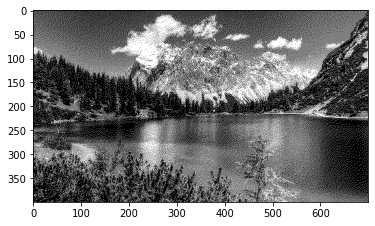

In [5]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [6]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

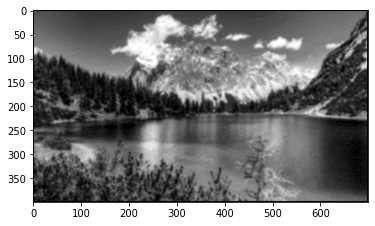

In [7]:
n = 5
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [8]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

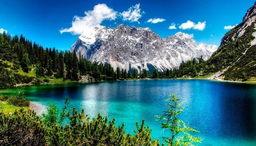

In [9]:
img

In [10]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [11]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [12]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

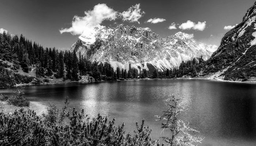

In [13]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [14]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [15]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 1, 3, 3], but got 3-dimensional input of size [1, 146, 256] instead

We need to insert a dimension for a batch at dim=0.

In [16]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [17]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [18]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [19]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

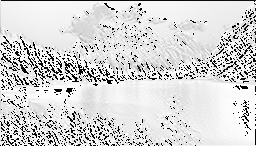

In [20]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

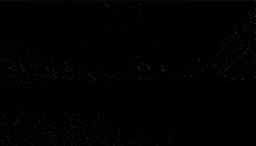

In [21]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [4]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

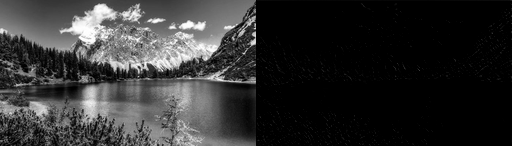

In [23]:
display(input, output)

### Identity

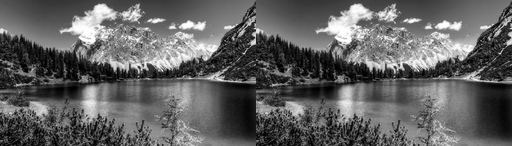

In [24]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


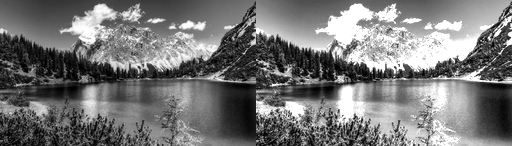

In [25]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


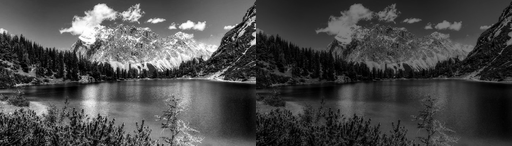

In [26]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


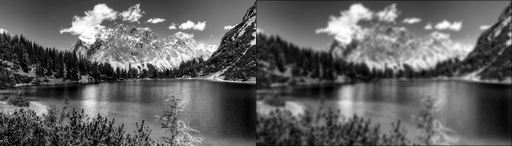

In [27]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


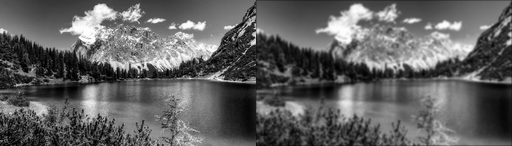

In [28]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


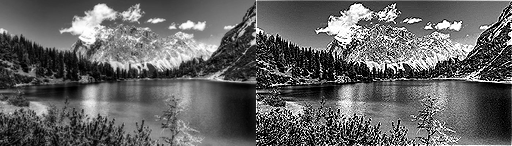

In [29]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


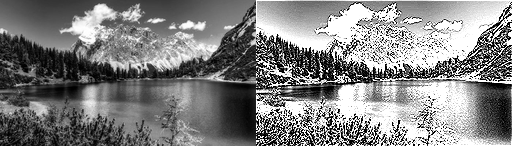

In [30]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


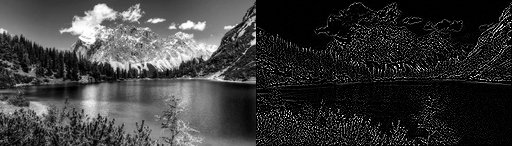

In [31]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

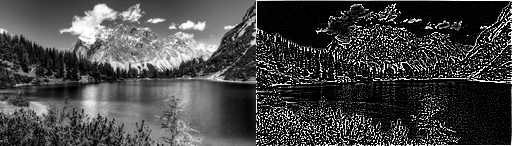

In [32]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

## 1. Edge detection algorithm implementation

### Prewitt

In [ ]:
# https://github.com/abhilas0/edge_detection/blob/master/edge_detection.ipynb

#define horizontal and Vertical sobel kernels
Hx = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
Hy = np.array([[-1, -1, -1],[0, 0, 0],[1, 1, 1]])

### Sobel

In [ ]:
# https://github.com/adamiao/sobel-filter-tutorial/blob/master/sobel_from_scratch.py

from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np

# #---------------------------------------------------------------------------------------------------------------------
# PART I - Transforming an image from color to grayscale
# #---------------------------------------------------------------------------------------------------------------------

# Here we import the image file as an array of shape (nx, ny, nz)
image_file = 'Images/original_image.PNG'
input_image = imread(image_file)  # this is the array representation of the input image
[nx, ny, nz] = np.shape(input_image)  # nx: height, ny: width, nz: colors (RGB)

# Extracting each one of the RGB components
r_img, g_img, b_img = input_image[:, :, 0], input_image[:, :, 1], input_image[:, :, 2]

# The following operation will take weights and parameters to convert the color image to grayscale
gamma = 1.400  # a parameter
r_const, g_const, b_const = 0.2126, 0.7152, 0.0722  # weights for the RGB components respectively
grayscale_image = r_const * r_img ** gamma + g_const * g_img ** gamma + b_const * b_img ** gamma

# This command will display the grayscale image alongside the original image
fig1 = plt.figure(1)
ax1, ax2 = fig1.add_subplot(121), fig1.add_subplot(122)
ax1.imshow(input_image)
ax2.imshow(grayscale_image, cmap=plt.get_cmap('gray'))
fig1.show()

# #---------------------------------------------------------------------------------------------------------------------
# PART II - Applying the Sobel operator
# #---------------------------------------------------------------------------------------------------------------------

"""
The kernels Gx and Gy can be thought of as a differential operation in the "input_image" array in the directions x and y 
respectively. These kernels are represented by the following matrices:
      _               _                   _                _
     |                 |                 |                  |
     | 1.0   0.0  -1.0 |                 |  1.0   2.0   1.0 |
Gx = | 2.0   0.0  -2.0 |    and     Gy = |  0.0   0.0   0.0 |
     | 1.0   0.0  -1.0 |                 | -1.0  -2.0  -1.0 |
     |_               _|                 |_                _|
"""

# Here we define the matrices associated with the Sobel filter
Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
[rows, columns] = np.shape(grayscale_image)  # we need to know the shape of the input grayscale image
sobel_filtered_image = np.zeros(shape=(rows, columns))  # initialization of the output image array (all elements are 0)

# Now we "sweep" the image in both x and y directions and compute the output
for i in range(rows - 2):
    for j in range(columns - 2):
        gx = np.sum(np.multiply(Gx, grayscale_image[i:i + 3, j:j + 3]))  # x direction
        gy = np.sum(np.multiply(Gy, grayscale_image[i:i + 3, j:j + 3]))  # y direction
        sobel_filtered_image[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)  # calculate the "hypotenuse"

# Display the original image and the Sobel filtered image
fig2 = plt.figure(2)
ax1, ax2 = fig2.add_subplot(121), fig2.add_subplot(122)
ax1.imshow(input_image)
ax2.imshow(sobel_filtered_image, cmap=plt.get_cmap('gray'))
fig2.show()

# Show both images
# plt.show()

# Save the filtered image in destination path
# plt.imsave('sobel_filtered_image.png', sobel_filtered_image, cmap=plt.get_cmap('gray'))

### Laplacian

In [ ]:
# https://iq.opengenus.org/laplacian-filter/

def create_log(sigma, size = 7):
    w = math.ceil(float(size)*float(sigma))

    if(w%2 == 0):
        w = w + 1

    l_o_g_mask = []

    w_range = int(math.floor(w/2))
    print("Going from " + str(-w_range) + " to " + str(w_range))
    for i in range_inc(-w_range, w_range):
        for j in range_inc(-w_range, w_range):
            l_o_g_mask.append(l_o_g(i,j,sigma))
    l_o_g_mask = np.array(l_o_g_mask)
    l_o_g_mask = l_o_g_mask.reshape(w,w)
    return l_o_g_mask

### 2. Image enhancement and image masking

In [89]:
import cv2 
import numpy as np

def line_enhancement(img, alpha=1.5):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=50, maxLineGap=10)
    mask = np.zeros_like(gray) 
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(mask, (x1,y1), (x2,y2), (255,255,255), 2)
            
    enhanced = cv2.addWeighted(img, alpha, mask, 1-alpha, 0)
    return enhanced 



img = cv2.imread("data/elon_1.jpg") 
    
enhanced_img = line_enhancement(img, 1)
cv2.imshow("Original Image", img)
cv2.imshow("Enhanced Image", enhanced_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.6.0) C:\b\abs_74oeeuevib\croots\recipe\opencv-suite_1664548340488\work\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


## 3. Median filtering

In [65]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

def gaussian_kernel(size, sigma):
    size = int(size) // 2 
    x, y = np.mgrid[-size:size+1, -size:size+1] 
    normal = 1 / (2.0 * np.pi * sigma**2) 
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal 
    return g 

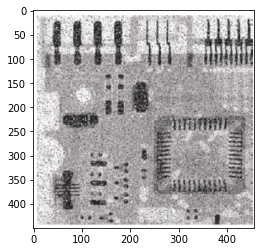

In [72]:
image = cv2.imread("data/pcb_noisy.png") 
plt.imshow(image)

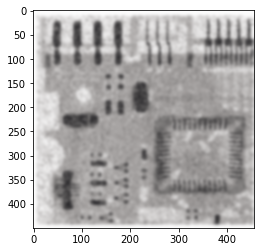

In [76]:

kernel = gaussian_kernel(17, 3)
blurred_image = cv2.filter2D(image, -1, kernel)
plt.imshow(blurred_image)

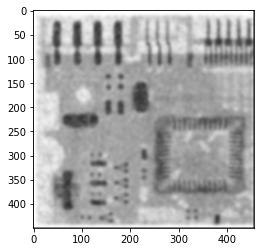

In [74]:
# Obtain the number of rows and columns 
# of the image
blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

m, n = blurred_image.shape
   
# Traverse the image. For every 3X3 area, 
# find the median of the pixels and
# replace the center pixel by the median
image_median = np.zeros([m, n])
  
for i in range(1, m-1):
    for j in range(1, n-1):
        temp = [blurred_image[i-1, j-1],
               blurred_image[i-1, j],
               blurred_image[i-1, j + 1],
               blurred_image[i, j-1],
               blurred_image[i, j],
               blurred_image[i, j + 1],
               blurred_image[i + 1, j-1],
               blurred_image[i + 1, j],
               blurred_image[i + 1, j + 1]]
        
        temp = sorted(temp)
        image_median[i, j]= temp[4]


plt.imshow(image_median, cmap='gray')



In [48]:
image_median.shape

(450, 456)

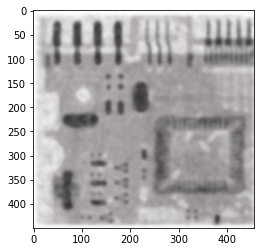

In [80]:
kernel_size = (7, 7) 
image_median = cv2.medianBlur(blurred_image, kernel_size[0])

plt.imshow(image_median, cmap='gray')